# Personalized Medicine: Redefining Cancer Treatment

- https://www.kaggle.com/c/msk-redefining-cancer-treatment/overview

- Predict the effect of Genetic Variants to enable Personalized Medicine

- Evalution : Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

# 1)- Import key Modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import time
import requests
import pickle

In [3]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from matplotlib import rcParams
#rcParams['figure.figsize'] = 11, 8
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline
#%pylab inline

In [4]:
# For ML Model and Evaluation


from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier


from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

Using TensorFlow backend.


In [5]:
# for text

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
%reload_ext version_information
%version_information numpy, pandas, matplotlib

Software versions
Python 3.7.5 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.10.2
OS Darwin 19.3.0 x86_64 i386 64bit
numpy 1.17.4
pandas 0.25.3
matplotlib 3.1.1
Sun Mar 22 23:37:57 2020 CET

# 2)-Loading Data

In [7]:
df_variant=pd.read_csv('training_variants')
df_variant.shape

(3321, 4)

In [8]:
df_variant.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [9]:
df_variant.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


deescibe() is only useful for numerical data analysis. With class i.e categorical variable, we wont get much useful information

In [10]:
df_variant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [11]:
df_variant.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

### Checking target variable

In [12]:
df_variant.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

So we have a multi class problem

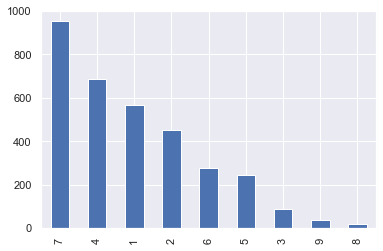

In [13]:
df_variant.Class.value_counts().plot(kind="bar")

In [14]:
df_variant.Class.value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

### Loading other dataset

In [15]:
df_text=pd.read_csv('training_text',sep='\|\|', engine='python', names=["ID","TEXT"], skiprows=1)
df_text.shape

(3321, 2)

In [16]:
df_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# 3)- Data Exploring

In [17]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [18]:
df_text.isnull().sum()

ID      0
TEXT    5
dtype: int64

### 3.1)- Dealing with Missing Values

As ID is same so, we can merge these two datasets

In [19]:
# to see what are those missing values and at what ID they occur
df_text[df_text.TEXT.isnull()]

,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [20]:
df_text2=df_text.fillna('Other')

In [21]:
df_text2.isnull().sum()

ID      0
TEXT    0
dtype: int64

In [22]:
df_text2[df_text2.TEXT=="Other"]

,ID,TEXT
1109,1109,Other
1277,1277,Other
1407,1407,Other
1639,1639,Other
2755,2755,Other


So we successfully filled values with "Other" string

In [23]:
df_text2.shape

(3321, 2)

### 3.2)- Merging two datasets

In [24]:
df_merge=pd.merge(df_variant, df_text2, on='ID')
df_merge.shape

(3321, 5)

In [25]:
df_merge.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [26]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3321 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [27]:
len(df_merge.Gene.unique())

264

In [28]:
len(df_merge.Variation.unique())

2996

In [29]:
len(df_merge.Class.unique())

9

# 4)- Text Cleaning

In [30]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hassansherwani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
stop_words=set(stopwords.words('english'))

In [32]:
def clean_text(total_text,ind,col):
    if type(total_text) is not int:
        string=""
        # Replacing special chars with space
        total_text=re.sub('[^a-zA-z0-9\n]',' ', str(total_text))
        #Replacing multiple space with single space
        total_text=re.sub('\s+',' ', str(total_text))
        # lower case
        total_text=total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        df_merge[col][ind]=string

In [33]:
# Apply function

for index, row in df_merge.iterrows():
    if type(row['TEXT']) is str:
        clean_text(row['TEXT'], index,'TEXT')

In [34]:
df_merge.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [35]:
len(df_merge.TEXT[0])

30841

In [36]:
# Compare with original uncleaned data

len(df_text.TEXT[0])

39672

# 5)- Preprocessing before Model Application

### 5.1)-Creat Train, Test and Validation data

In [37]:
y_true=df_merge["Class"].values
df_merge['Gene']=df_merge.Gene.str.replace('\s+', ' ')
df_merge['Variation']=df_merge.Variation.str.replace('\s+', ' ')

In [38]:
y_true[:10]

array([1, 2, 2, 3, 4, 4, 5, 1, 4, 4])

In [39]:
from sklearn.model_selection import train_test_split
# 1st split into train and test
X_train, test_df, y_train, y_test=train_test_split(df_merge, y_true, stratify=y_true, test_size=0.2)

# 2nd split train data into validation data for cross validation

train_df, cv_df, y_train, y_cv=train_test_split(X_train, y_train,stratify=y_train, test_size=0.2 )

In [40]:
# shape[0] shows only rows
print(X_train.shape[0])
print(train_df.shape[0])
print(test_df.shape[0])
print(cv_df.shape[0])

2656
2124
665
532


Overall all these dataframes contain full information of that main dataframe

In [41]:
train_df.head(2)

,ID,Gene,Variation,Class,TEXT
74,74,RAD50,Deletion,1,mre11 rad50 nbs1 function protein complex cent...
1998,1998,MAP2K1,Q56_V60del,7,effective systemic therapy exists patients met...


### 5.2)- check data split distribution 

In [42]:
train_class_distribution=train_df["Class"].value_counts().sort_index()
test_class_distribution=test_df["Class"].value_counts().sort_index()
cv_class_distribution=cv_df["Class"].value_counts().sort_index()

In [43]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

In [44]:
test_class_distribution

1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64

In [45]:
cv_class_distribution

1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64

### 5.3)-Visualize

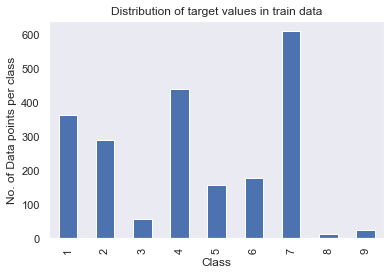

In [46]:
my_colors='rgbkymc'
train_class_distribution.plot(kind="bar")
plt.xlabel('Class')
plt.ylabel('No. of Data points per class')
plt.title("Distribution of target values in train data")
plt.grid()
plt.show()

In [47]:
train_df["Class"].value_counts(normalize=True)

7    0.286723
4    0.206685
1    0.170904
2    0.136064
6    0.082863
5    0.072976
3    0.026836
9    0.011299
8    0.005650
Name: Class, dtype: float64

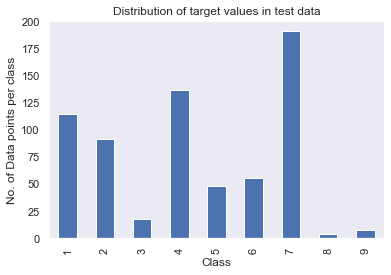

In [48]:
my_colors='rgbkymc'
test_class_distribution.plot(kind="bar")
plt.xlabel('Class')
plt.ylabel('No. of Data points per class')
plt.title("Distribution of target values in test data")
plt.grid()
plt.show()

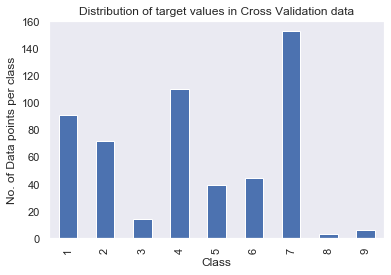

In [49]:
my_colors='rgbkymc'
cv_class_distribution.plot(kind="bar")
plt.xlabel('Class')
plt.ylabel('No. of Data points per class')
plt.title("Distribution of target values in Cross Validation data")
plt.grid()
plt.show()

Class distribution is consistent in all three division. It will cure our model from any selection biaseness problem

# 6)- Building a Random model

In [50]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

### 6a.For Cross validation

In [51]:
#we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.4297338295479585


### 6b. For Test-Set 

In [52]:
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.4271345752887226


In [53]:
# for prob. of each class
test_predicted_y[:5]

array([[0.15364379, 0.18704204, 0.01231415, 0.27264831, 0.04169195,
        0.03441182, 0.14976252, 0.05098826, 0.09749716],
       [0.26359156, 0.07025254, 0.01029281, 0.12320808, 0.20668573,
        0.10132509, 0.04670673, 0.16662686, 0.01131059],
       [0.14191007, 0.11028604, 0.07625439, 0.08921548, 0.09430881,
        0.18037282, 0.12787579, 0.15673741, 0.02303921],
       [0.16579605, 0.1978004 , 0.00619125, 0.05110983, 0.10958449,
        0.16572419, 0.05795194, 0.2050909 , 0.04075095],
       [0.10155438, 0.04132611, 0.16374086, 0.06810422, 0.16612481,
        0.17048438, 0.11751061, 0.10262148, 0.06853316]])

In [54]:
# convert this probability into class_prob 
predicted_y =np.argmax(test_predicted_y, axis=1)

In [55]:
predicted_y[:50]

array([3, 0, 5, 7, 5, 7, 5, 6, 4, 0, 8, 3, 0, 7, 4, 7, 1, 6, 8, 2, 5, 2,
       6, 2, 6, 7, 5, 3, 7, 3, 7, 4, 2, 8, 5, 5, 4, 1, 8, 6, 3, 7, 0, 4,
       1, 2, 8, 6, 2, 4])

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [56]:
predicted_y = predicted_y + 1

In [57]:
predicted_y[:50]

array([4, 1, 6, 8, 6, 8, 6, 7, 5, 1, 9, 4, 1, 8, 5, 8, 2, 7, 9, 3, 6, 3,
       7, 3, 7, 8, 6, 4, 8, 4, 8, 5, 3, 9, 6, 6, 5, 2, 9, 7, 4, 8, 1, 5,
       2, 3, 9, 7, 3, 5])

### 6c.Confusion Matrix

In [58]:
y_test[:10]

array([6, 7, 1, 1, 5, 2, 7, 4, 2, 4])

In [59]:
C = confusion_matrix(y_test, predicted_y)

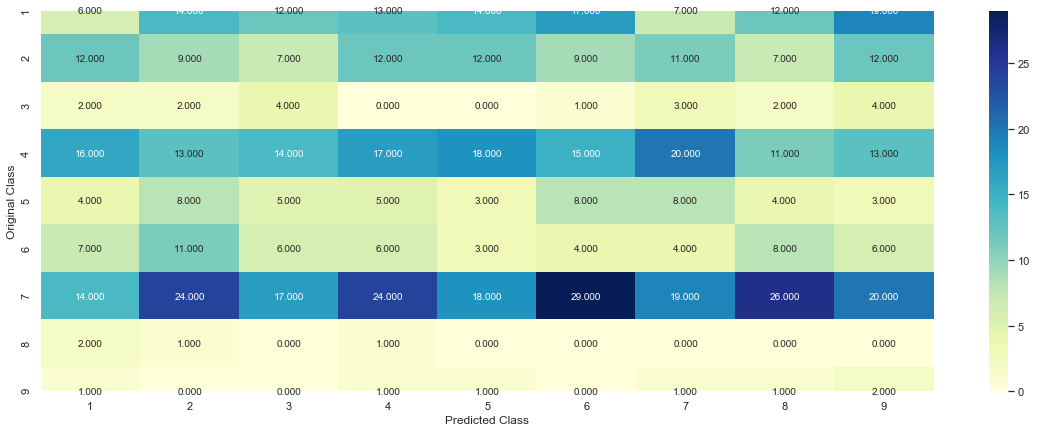

In [60]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 6.d.Precision matrix

In [61]:
P =(C/C.sum(axis=0))

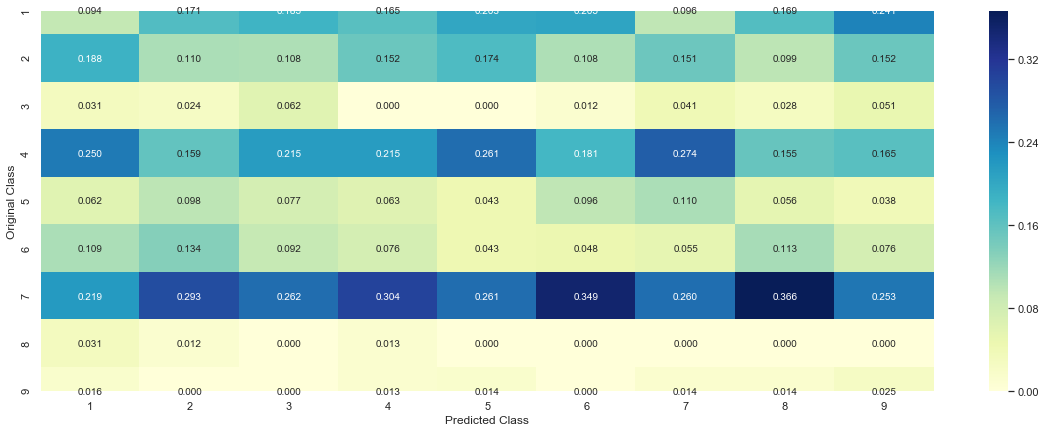

In [62]:
plt.figure(figsize=(20,7))
sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

### 6.e.Recall Matrix

In [63]:
A =(((C.T)/(C.sum(axis=1))).T)

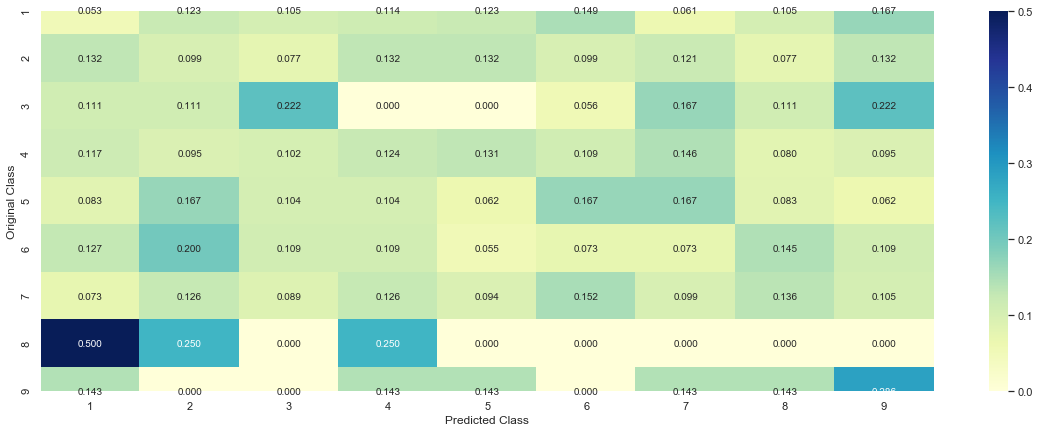

In [64]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# END Of NOTEBOOK2